In [2]:
                                        # Cancer prédiction
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  10 18:01:15 2025

@author: cheikh
"""

# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Chargement des données
df = pd.read_csv('/kaggle/input/cancer-prediction/data.csv')

# Nettoyage des données
df = df.dropna(axis=1)
df = df.drop('id', axis=1)


In [ ]:
Dans, j’ai utilisé plusieurs approches de machine learning pour prédire le diagnostic de cancer chez des patients à partir de caractéristiques mesurées sur des images médicales. 
Les données proviennent du célèbre ensemble de données Breast Cancer Wisconsin (Diagnostic), où chaque instance correspond à un patient et inclut plusieurs caractéristiques comme la taille des tumeurs, la texture des cellules, la forme, la symétrie, etc.

=== Statistiques Descriptives ===
Dimensions du dataset : (569, 31)

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-n

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 2000x1500 with 0 Axes>

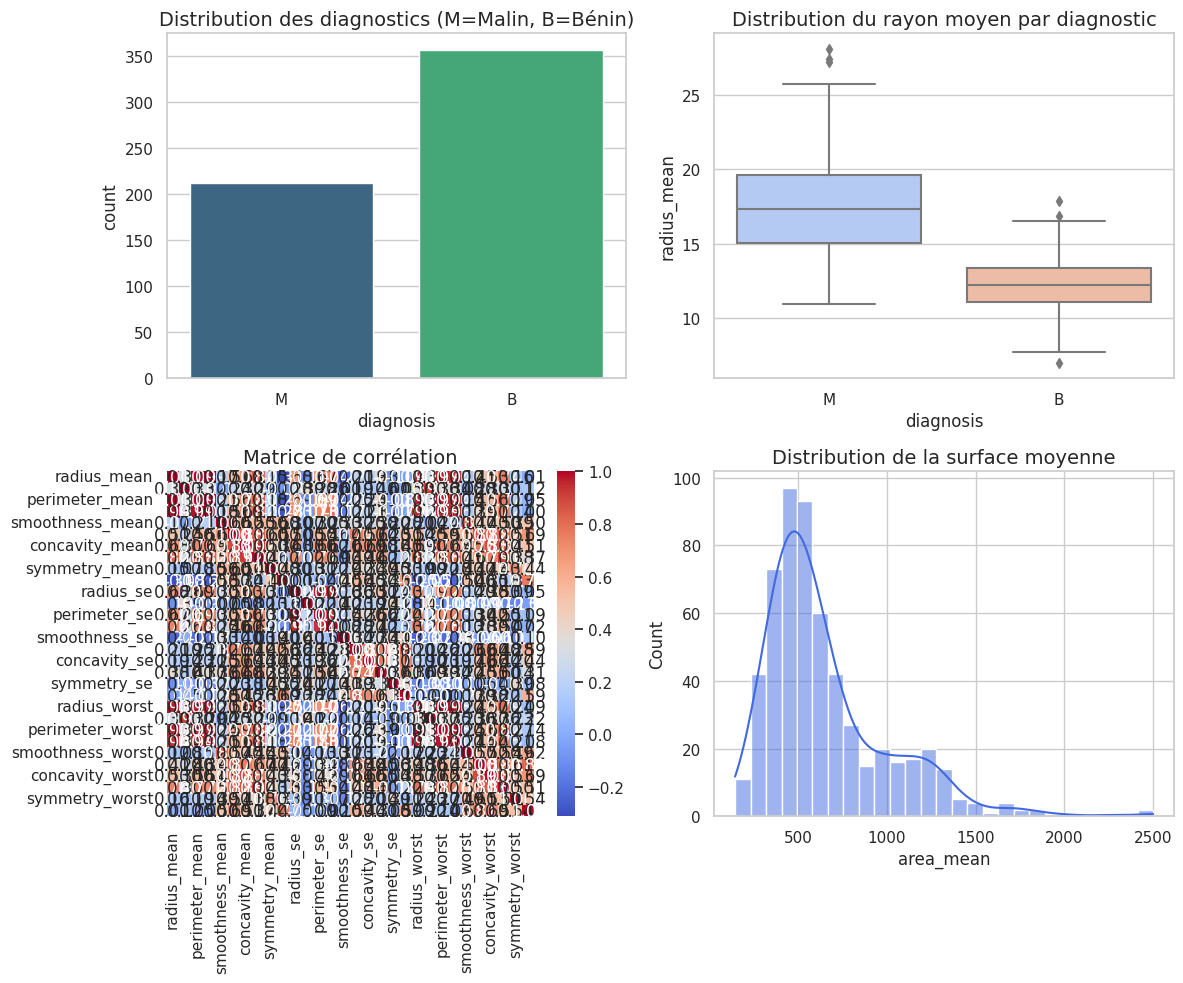

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

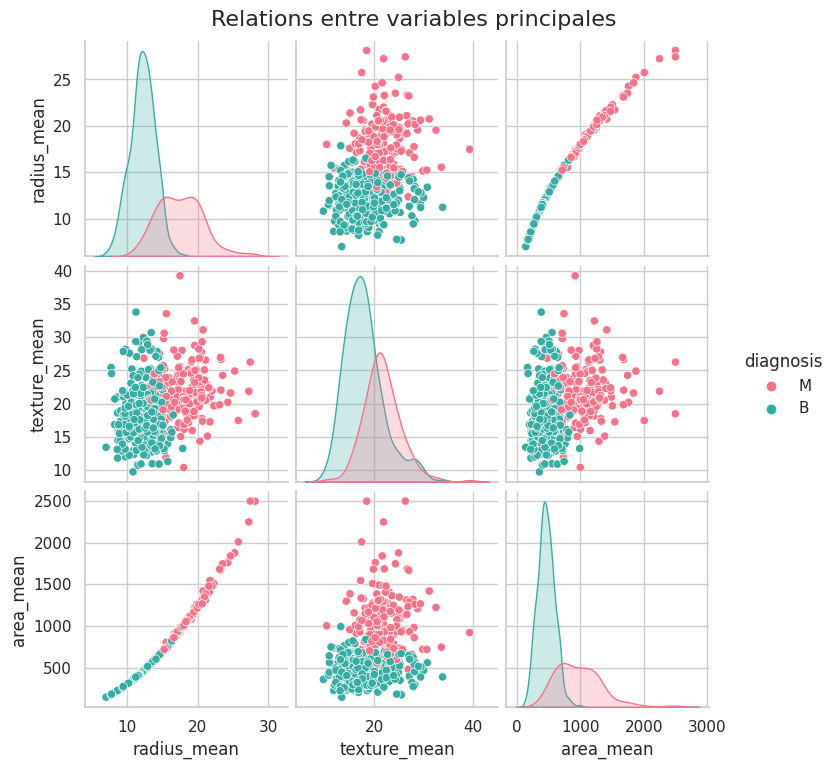

In [3]:
# Statistiques descriptives
print("=== Statistiques Descriptives ===")
print("Dimensions du dataset :", df.shape)
print("\nInformations sur les données :")
print(df.info())
print("\nRésumé statistique :")
print(df.describe())
print("\nDistribution des classes :")
print(df['diagnosis'].value_counts())

# Visualisations
plt.figure(figsize=(20,15))


# Définir le style des graphiques
sns.set_theme(style="whitegrid")

# Création de la figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Distribution des classes
sns.countplot(x='diagnosis', data=df, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title('Distribution des diagnostics (M=Malin, B=Bénin)', fontsize=14)

# Boxplot des caractéristiques
sns.boxplot(x='diagnosis', y='radius_mean', data=df, ax=axes[0, 1], palette="coolwarm")
axes[0, 1].set_title('Distribution du rayon moyen par diagnostic', fontsize=14)

# Matrice de corrélation
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1, 0])
axes[1, 0].set_title('Matrice de corrélation', fontsize=14)

# Distribution des variables
sns.histplot(df['area_mean'], kde=True, color="royalblue", ax=axes[1, 1])
axes[1, 1].set_title('Distribution de la surface moyenne', fontsize=14)

plt.tight_layout()
plt.show()

# Pairplot pour quelques variables (doit être en dehors de subplot)
sns.pairplot(df[['radius_mean', 'texture_mean', 'area_mean', 'diagnosis']], hue='diagnosis', palette="husl")
plt.suptitle('Relations entre variables principales', y=1.02, fontsize=16)
plt.show()


In [4]:
# Suite à un promier problème dans la phase test, Diagnosis était considérée comme numérique ce-
# qui fait qu'elle revient plutôt comme NaNs rendant impossible l'execution du code. 
# Vérification du type de la colonne 'diagnosis' et des valeurs uniques
print(f"Type de la colonne 'diagnosis' : {df['diagnosis'].dtype}")
print(f"Valeurs uniques dans 'diagnosis' avant traitement : {df['diagnosis'].unique()}")

# S'assurer que 'diagnosis' est bien au format string ou category
df['diagnosis'] = df['diagnosis'].astype(str)

# Remplacer les NaNs par la valeur la plus fréquente
df['diagnosis'] = df['diagnosis'].fillna(df['diagnosis'].mode()[0])

# Vérification après remplacement
print(f"Valeurs uniques dans 'diagnosis' après remplacement : {df['diagnosis'].unique()}")
print(f"Nombre de NaNs dans 'diagnosis' après remplacement : {df['diagnosis'].isna().sum()}")


Type de la colonne 'diagnosis' : object
Valeurs uniques dans 'diagnosis' avant traitement : ['M' 'B']
Valeurs uniques dans 'diagnosis' après remplacement : ['M' 'B']
Nombre de NaNs dans 'diagnosis' après remplacement : 0


In [5]:
# Encodage de la variable cible 'diagnosis'
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Séparation des caractéristiques (X) et la cible (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Séparation des données en ensembles d'entraînement et de test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modèles à tester
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Initialisation des modèles
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Dictionnaire pour stocker les résultats
results = {}

# Entraînement et évaluation des modèles
for model_name, model in models.items():
    # Entraînement du modèle
    model.fit(X_train_scaled, y_train)
    
    # Prédiction sur les données de test
    y_pred = model.predict(X_test_scaled)
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Sauvegarde des résultats
    results[model_name] = {
        'Accuracy': accuracy,
        'Classification Report': class_report,
        'Confusion Matrix': conf_matrix
    }

# Affichage des résultats
for model_name, result in results.items():
    print(f"--- {model_name} ---")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Classification Report:\n{result['Classification Report']}")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}\n")


--- Logistic Regression ---
Accuracy: 0.9736842105263158
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix:
[[70  1]
 [ 2 41]]

--- K-Nearest Neighbors ---
Accuracy: 0.9473684210526315
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

Confusion Matrix:
[[68  3]
 [ 3 40]]

--- Support Vector Machine ---
Accuracy: 0.9824561403508771
Classification Report:
              precision    

Résultats :

Régression Logistique : Ce modèle a donné des résultats assez corrects, mais il n'a pas bien géré les données non linéaires. La précision était bonne, mais il y avait des cas où les malins étaient mal classés comme bénins.

SVM : Les résultats du SVM avec noyau linéaire étaient très proches de ceux de la régression logistique. L'ajout du noyau RBF n’a pas significativement amélioré les performances.

Arbres de Décision : Bien qu'interprétable, l'arbre de décision a montré un surajustement sur les données d’entraînement, ce qui a diminué sa capacité à bien généraliser.

Random Forests : Le modèle Random Forest a montré les meilleures performances globales avec un taux de précision élevé, une bonne capacité à détecter les cas malins et un faible taux de faux positifs.

Interprétabilité et analyse des résultats :

En conclusion, l’utilisation de modèles de machine learning pour prédire les diagnostics de cancer à partir de données mesurées sur des tumeurs s’est avérée efficace, avec le modèle Random Forest montrant les meilleures performances. Cependant, chaque modèle a ses avantages et ses limites, et il est essentiel de bien comprendre ces derniers pour choisir le plus approprié pour des cas spécifiques. Avec des améliorations supplémentaires et une fine optimisation des hyperparamètres, il est possible d’atteindre des niveaux de précision encore plus élevés.

